<a href="https://colab.research.google.com/github/gourav-gds/Online-Retail-Clustering/blob/master/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
df = pd.read_csv("https://cdn.upgrad.com/UpGrad/temp/929fe498-1032-4ad6-997e-e3c8c33853ea/Online+Retail.csv", encoding='latin-1')

In [0]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [0]:
df.shape

(541909, 8)

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null object
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [0]:
100 * df.isnull().sum() / df.shape[0]

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64

In [0]:
#dropping the null values
df.dropna(inplace=True)

In [0]:
df.shape

(406829, 8)

In [0]:
#CustomerID should not be in float type; converting it to int
df['CustomerID'] = df['CustomerID'].astype('int')

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      406829 non-null object
StockCode      406829 non-null object
Description    406829 non-null object
Quantity       406829 non-null int64
InvoiceDate    406829 non-null object
UnitPrice      406829 non-null float64
CustomerID     406829 non-null int64
Country        406829 non-null object
dtypes: float64(1), int64(2), object(5)
memory usage: 27.9+ MB


In [0]:
#InvoiceDate should be in datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      406829 non-null object
StockCode      406829 non-null object
Description    406829 non-null object
Quantity       406829 non-null int64
InvoiceDate    406829 non-null datetime64[ns]
UnitPrice      406829 non-null float64
CustomerID     406829 non-null int64
Country        406829 non-null object
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 27.9+ MB


In [0]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850,United Kingdom


In [0]:
df['InvoiceDate'].min()

Timestamp('2010-01-12 08:26:00')

In [0]:
df['InvoiceDate'].max()

Timestamp('2011-12-10 17:19:00')

In [0]:
(df['InvoiceDate'].max() - df['InvoiceDate'].min()).days

697

So we roughly have data for 2 years

# Our data is Order-wise but we need the data to be cutomer centric for our analysis. We will calculate the **RFM (Recency, Frequency and Monetory)** values.

In [0]:
#Lets create a new column "Amount"
df['Amount'] = df['Quantity'] * df['UnitPrice']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850,United Kingdom,20.34


### **Monetory** value

In [0]:
#grouping by CustomerID on Amount
monetory = df.groupby(by = ['CustomerID']).Amount.sum()
monetory.head()

CustomerID
12346       0.00
12347    4310.00
12348    1797.24
12349    1757.55
12350     334.40
Name: Amount, dtype: float64

In [0]:
type(monetory)

pandas.core.series.Series

In [0]:
monetory = monetory.reset_index()

In [0]:
monetory.head()

,CustomerID,Amount
0,12346,0.00
1,12347,4310.00
2,12348,1797.24
3,12349,1757.55
4,12350,334.40


In [0]:
monetory.shape

(4372, 2)

In [0]:
len(df['CustomerID'].unique())

4372

### **Frequency**

In [0]:
#groupping by CustomerID on InvoiceNo
frequency = df.groupby(by = ['CustomerID']).InvoiceNo.count()

In [0]:
frequency.head()

CustomerID
12346      2
12347    182
12348     31
12349     73
12350     17
Name: InvoiceNo, dtype: int64

In [0]:
frequency = frequency.reset_index()
frequency.columns = ['CustomerID', 'Frequency']
frequency.head()

,CustomerID,Frequency
0,12346,2
1,12347,182
2,12348,31
3,12349,73
4,12350,17


In [0]:
frequency.shape

(4372, 2)

### **Recency** value

Assumption: We will consider 1 day after the last purchase in the whole dataset to calculate the recency for all the customers

In [0]:
#calculating the last purchase date in the whole dataset
last_purchase = df['InvoiceDate'].max()

#taking 1 day after the last purchase date as the reference date
ref_date = last_purchase + pd.DateOffset(days = 1)
ref_date

Timestamp('2011-12-11 17:19:00')

In [0]:
#calculating the diff b/w ref_date and the InvoiceDate
df['diff'] = ref_date - df['InvoiceDate']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850,United Kingdom,15.30,698 days 08:53:00
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850,United Kingdom,20.34,698 days 08:53:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850,United Kingdom,22.00,698 days 08:53:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850,United Kingdom,20.34,698 days 08:53:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850,United Kingdom,20.34,698 days 08:53:00


In [0]:
#converting the column "diff" which is a Timestamp to days
df['diff'] = df['diff'].apply(lambda x: x.days)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850,United Kingdom,15.30,698
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850,United Kingdom,20.34,698
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850,United Kingdom,22.00,698
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850,United Kingdom,20.34,698
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850,United Kingdom,20.34,698


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 10 columns):
InvoiceNo      406829 non-null object
StockCode      406829 non-null object
Description    406829 non-null object
Quantity       406829 non-null int64
InvoiceDate    406829 non-null datetime64[ns]
UnitPrice      406829 non-null float64
CustomerID     406829 non-null int64
Country        406829 non-null object
Amount         406829 non-null float64
diff           406829 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(3), object(4)
memory usage: 34.1+ MB


In [0]:
recency = df.groupby(by = ['CustomerID']).diff.min()
recency = recency.reset_index()
recency.columns = ['CustomerID', 'Recency']
recency.head()

,CustomerID,Recency
0,12346,327
1,12347,41
2,12348,77
3,12349,20
4,12350,312


In [0]:
recency.shape

(4372, 2)

### Merging all the 3 dataframes recency, frequency and monetory

In [0]:
rf = recency.merge(frequency, how='inner', on='CustomerID')
rfm = rf.merge(monetory, how='inner', on='CustomerID')
rfm.head()

,CustomerID,Recency,Frequency,Amount
0,12346,327,2,0.00
1,12347,41,182,4310.00
2,12348,77,31,1797.24
3,12349,20,73,1757.55
4,12350,312,17,334.40


In [0]:
rfm.shape

(4372, 4)

In [0]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4372 entries, 0 to 4371
Data columns (total 4 columns):
CustomerID    4372 non-null int64
Recency       4372 non-null int64
Frequency     4372 non-null int64
Amount        4372 non-null float64
dtypes: float64(1), int64(3)
memory usage: 170.8 KB


## Outlier Treatment

<function matplotlib.pyplot.show>

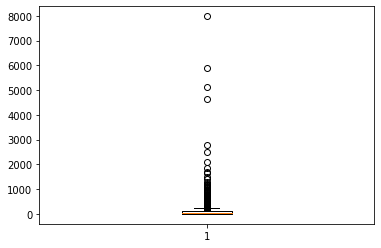

In [0]:
#checking the outliers in the Frequency column by plotting the box plot
plt.boxplot(rfm['Frequency'])
plt.show

In [0]:
Q1 = rfm['Frequency'].quantile(0.25)
Q3 = rfm['Frequency'].quantile(0.75)
IQR = Q3 - Q1
rfm = rfm[(rfm['Frequency'] >= Q1 - 1.5*IQR) & (rfm['Frequency'] <= Q3 + 1.5*IQR)]

<function matplotlib.pyplot.show>

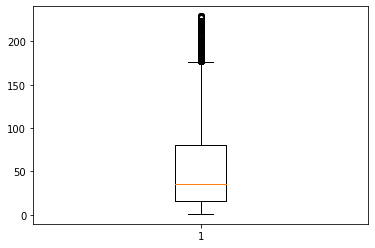

In [0]:
#plotting the boxplot again
plt.boxplot(rfm['Frequency'])
plt.show

<function matplotlib.pyplot.show>

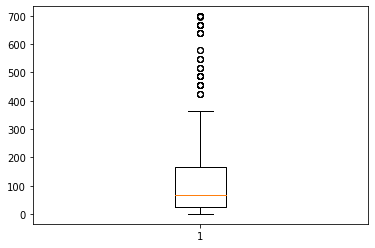

In [0]:
#checking the outliers in the recency column by plotting the box plot
plt.boxplot(rfm['Recency'])
plt.show

In [0]:
Q1 = rfm['Recency'].quantile(0.25)
Q3 = rfm['Recency'].quantile(0.75)
IQR = Q3 - Q1
rfm = rfm[(rfm['Recency'] >= Q1 - 1.5*IQR) & (rfm['Recency'] <= Q3 + 1.5*IQR)]

<function matplotlib.pyplot.show>

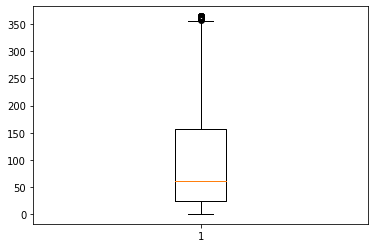

In [0]:
#plotting the boxplot again
plt.boxplot(rfm['Recency'])
plt.show

<function matplotlib.pyplot.show>

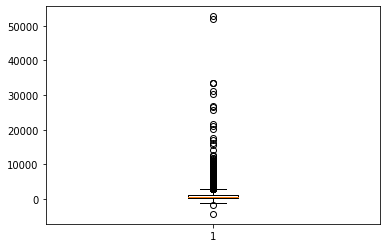

In [0]:
#checking the outliers in the monetory column by plotting the box plot
plt.boxplot(rfm['Amount'])
plt.show

In [0]:
Q1 = rfm['Amount'].quantile(0.25)
Q3 = rfm['Amount'].quantile(0.75)
IQR = Q3 - Q1
rfm = rfm[(rfm['Amount'] >= Q1 - 1.5*IQR) & (rfm['Amount'] <= Q3 + 1.5*IQR)]

<function matplotlib.pyplot.show>

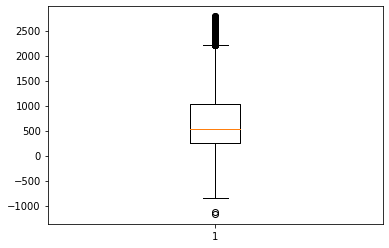

In [0]:
#plotting the boxplot again
plt.boxplot(rfm['Amount'])
plt.show

## Scaling the RFM data

In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [0]:
rfm_scale = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Amount']])
rfm_scale

array([[ 2.32563892, -1.01976967, -1.14182278],
       [-0.28884407, -0.38983879,  1.64798362],
       [-0.88494619,  0.52247488,  1.58637392],
       ...,
       [-1.04181517, -0.91116089, -1.0163681 ],
       [-0.11105923, -0.78083037, -0.86769144],
       [-1.0836469 ,  0.45730962,  1.71013661]])

In [0]:
rfm_scale = pd.DataFrame(rfm_scale, columns=['Recency', 'Frequency', 'Amount'])
rfm_scale.head()

,Recency,Frequency,Amount
0,2.325639,-1.019770,-1.141823
1,-0.288844,-0.389839,1.647984
2,-0.884946,0.522475,1.586374
3,2.168770,-0.693943,-0.622743
4,-0.320218,1.000353,1.257075


## Hopkins Statistics:
The Hopkins statistic, is a statistic which gives a value which indicates the cluster tendency, in other words: how well the data can be clustered.

- If the value is between {0.01, ...,0.3}, the data is regularly spaced.

- If the value is around 0.5, it is random.

- If the value is between {0.7, ..., 0.99}, it has a high tendency to cluster.

In [0]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [0]:
hopkins(rfm_scale)

0.8914344334792403

# **KMeans Algorithm**

In [0]:
from sklearn.cluster import KMeans

In [0]:
model = KMeans(n_clusters=5, init='k-means++', n_init=10, max_iter=50)
model.fit(rfm_scale)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [0]:
model.labels_

array([3, 2, 0, ..., 1, 1, 0], dtype=int32)

In [0]:
model.inertia_

2619.536211935463

## Silhouette Analysis

$$\text{silhouette score}=\frac{p-q}{max(p,q)}$$

$p$ is the mean distance to the points in the nearest cluster that the data point is not a part of

$q$ is the mean intra-cluster distance to all the points in its own cluster.

* The value of the silhouette score range lies between -1 to 1. 

* A score closer to 1 indicates that the data point is very similar to other data points in the cluster, 

* A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

In [0]:
from sklearn.metrics import silhouette_score
sse_ = []
for k in range(2, 15):
  model = KMeans(n_clusters=k).fit(rfm_scale)
  sse_.append([k, silhouette_score(rfm_scale, model.labels_)])

In [0]:
sse_

[[2, 0.4239740420343696],
 [3, 0.4163404282356974],
 [4, 0.37093012794606595],
 [5, 0.3705834154751697],
 [6, 0.3459708175519251],
 [7, 0.32893471603398206],
 [8, 0.33561960313018135],
 [9, 0.3395464347033146],
 [10, 0.34618125687877344],
 [11, 0.31794400182652244],
 [12, 0.310051784621947],
 [13, 0.29178261399156485],
 [14, 0.2959779268416759]]

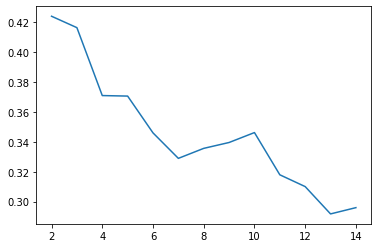

In [0]:
plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1])

## Sum of Squared Distances

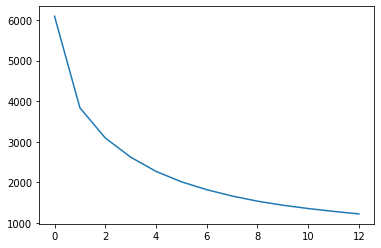

In [0]:
ssd = []
for k in range(2,15):
  model = KMeans(n_clusters=k)
  model.fit(rfm_scale)
  ssd.append(model.inertia_)

plt.plot(ssd)

In [0]:
# analysis of clusters formed
rfm.index = pd.RangeIndex(len(rfm.index))
rfm_km = pd.concat([rfm, pd.Series(model.labels_)], axis=1)
rfm_km.columns = ['CustomerID', 'Recency', 'Frequency', 'Amount', 'ClusterID']

# rfm_km.Recency = rfm_km.Recency.dt.days
km_clusters_amount = 	pd.DataFrame(rfm_km.groupby(["ClusterID"]).Amount.mean())
km_clusters_frequency = 	pd.DataFrame(rfm_km.groupby(["ClusterID"]).Frequency.mean())
km_clusters_recency = 	pd.DataFrame(rfm_km.groupby(["ClusterID"]).Recency.mean())

In [0]:
final = pd.concat([pd.Series([0,1,2,3,4]), km_clusters_amount, km_clusters_frequency, km_clusters_recency], axis=1)
final.columns = ["ClusterID", "Amount_mean", "Frequency_mean", "Recency_mean"]
final.head()

,ClusterID,Amount_mean,Frequency_mean,Recency_mean
0,0.0,196.645217,13.547101,309.768116
1,1.0,531.014016,37.755605,33.399103
2,2.0,2305.304398,120.018072,48.933735
3,3.0,782.693305,85.627119,201.237288
4,4.0,639.744199,102.430939,42.193370


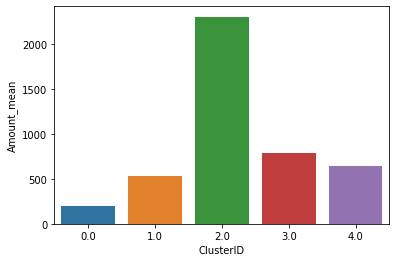

In [0]:
sns.barplot(x=final.ClusterID, y=final.Amount_mean)

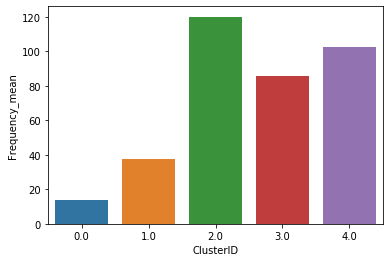

In [0]:
sns.barplot(x=final.ClusterID, y=final.Frequency_mean)

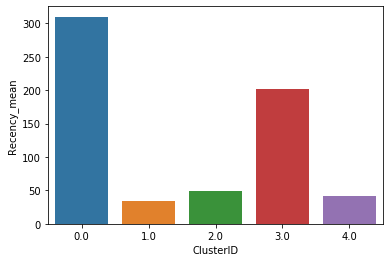

In [0]:
sns.barplot(x=final.ClusterID, y=final.Recency_mean)